In [100]:
import networkx as nx
import numpy as np
import pandas as pd
from scipy.sparse import csc_matrix
from torch_geometric.utils import k_hop_subgraph
import torch

##  Cora node mapping

In [101]:
cora_text = pd.read_csv('dataset/cora/cora_text.tsv', delimiter='\t')
node_id_mapping = dict(zip(cora_text['pid'].tolist(),range(len(cora_text['pid'].tolist()))))
node_id_mapping[1105428]

1370

In [102]:
sample = pd.read_excel('dataset/cora/实验样本.xlsx')
sample

,pid1,pid2,title1,title2,abstract1,abstract2,label1,label2,link
0,101662,101811,Title: Learning from positive data,Title: Programming Research Group A LEARNABILI...,Abstract: Gold showed in 1967 that not even re...,Abstract: This paper compares direct reinforce...,Theory,Theory,Yes
1,22886,1105428,Title: Continuous Case-Based Reasoning,Title: From Theory Refinement to KB Maintenanc...,Abstract: Case-based reasoning systems have tr...,Abstract: Since we consider theory refinement ...,Case_Based,Rule_Learning,No
2,1122642,34257,Title: Word Perfect Corp. LIA: A Location-Inde...,Title: A Self-Adjusting Dynamic Logic Module,Abstract: Most Artificial Neural Networks (ANN...,Abstract: This paper presents an ASOCS (Adapti...,Neural_Networks,Neural_Networks,Yes
3,22886,1120444,Title: Continuous Case-Based Reasoning,Title: Systematic Evaluation of Design Decisio...,Abstract: Case-based reasoning systems have tr...,Abstract: Two important goals in the evaluatio...,Case_Based,Case_Based,Yes
4,10798,20193,Title: Learning physical descriptions from fun...,Title: The Structure-Mapping Engine: Algorithm...,"Abstract: Technical Report 94-07 February 7, 1...",Abstract: This paper describes the Structure-M...,Case_Based,Case_Based,Yes
5,30901,642894,Title: Lookahead and Pathology in Decision Tre...,Title: Rates of convergence of the Hastings an...,Abstract: The standard approach to decision tr...,Abstract: We apply recent results in Markov ch...,Theory,Probabilistic_Methods,No
6,578650,578649,Title: Collective Memory Search 1 Collective M...,Title: Augmenting Collective Adaptation with S...,Abstract: The results reported here empiricall...,Abstract: We have integrated the distributed s...,Genetic_Algorithms,Genetic_Algorithms,Yes
7,10798,91853,Title: Learning physical descriptions from fun...,Title: GIT-CC-92/60 A Model-Based Approach to ...,"Abstract: Technical Report 94-07 February 7, 1...",Abstract: A major issue in case-basedsystems i...,Case_Based,Case_Based,No
8,101662,41666,Title: Learning from positive data,Title: Separating Formal Bounds from Practical...,Abstract: Gold showed in 1967 that not even re...,Abstract: We present a distribution model for ...,Theory,Theory,No
9,141347,1119708,Title: Adapting Crossover in a Genetic Algorithm,Title: On The State of Evolutionary Computation,"Abstract: Traditionally, genetic algorithms ha...",Abstract: In the past few years the evolutiona...,Genetic_Algorithms,Genetic_Algorithms,Yes


## 导入cites

In [103]:
cites_path = 'dataset/cora/cora.cites'
content_path = 'dataset/coracora.content'

edge_index = pd.read_csv(cites_path, delimiter='\t', header=None)
edge_index = torch.tensor(edge_index.values).T
edge_index

tensor([[     35,      35,      35,  ...,  853118,  853155,  954315],
        [   1033,  103482,  103515,  ..., 1140289,  853118, 1155073]])

## 抽取子图

In [104]:
from torch import Tensor

subgraphs = []
for i in range(len(sample)):

    pid1 = sample.loc[i, 'pid1']
    pid2 = sample.loc[i, 'pid2']
    print(pid1, pid2)
    sub_nodes, sub_edge_index, mapping, _ = k_hop_subgraph([int(pid1), int(pid2)], 2, edge_index, relabel_nodes=False)
    src, dst = mapping.tolist()

    # Remove target link from the subgraph.
    mask1 = (sub_edge_index[0] != src) | (sub_edge_index[1] != dst)
    mask2 = (sub_edge_index[0] != dst) | (sub_edge_index[1] != src)
    sub_edge_index = sub_edge_index[:, mask1 & mask2].tolist()

    subgraphs.append(sub_edge_index)
    
sample['subgraph_1hop'] = subgraphs
sample = sample[['pid1', 'pid2', 'title1', 'title2', 'abstract1', 'abstract2', 'label1', 'label2', 'link', 'subgraph_1hop']]
sample

101662 101811
22886 1105428
1122642 34257
22886 1120444
10798 20193
30901 642894
578650 578649
10798 91853
101662 41666
141347 1119708
578650 1130454
387795 593559
1122642 1130069
6767 1106103
78994 662572
78994 1135899
30901 11339
141347 1113831
387795 128540
6767 69418


,pid1,pid2,title1,title2,abstract1,abstract2,label1,label2,link,subgraph_1hop
0,101662,101811,Title: Learning from positive data,Title: Programming Research Group A LEARNABILI...,Abstract: Gold showed in 1967 that not even re...,Abstract: This paper compares direct reinforce...,Theory,Theory,Yes,"[[8224, 12350, 15429, 23738, 23738, 27895, 511..."
1,22886,1105428,Title: Continuous Case-Based Reasoning,Title: From Theory Refinement to KB Maintenanc...,Abstract: Case-based reasoning systems have tr...,Abstract: Since we consider theory refinement ...,Case_Based,Rule_Learning,No,"[[4274, 4649, 6741, 8703, 8703, 10435, 10798, ..."
2,1122642,34257,Title: Word Perfect Corp. LIA: A Location-Inde...,Title: A Self-Adjusting Dynamic Logic Module,Abstract: Most Artificial Neural Networks (ANN...,Abstract: This paper presents an ASOCS (Adapti...,Neural_Networks,Neural_Networks,Yes,"[[34257, 34257, 34257, 34257, 34257, 34263, 34..."
3,22886,1120444,Title: Continuous Case-Based Reasoning,Title: Systematic Evaluation of Design Decisio...,Abstract: Case-based reasoning systems have tr...,Abstract: Two important goals in the evaluatio...,Case_Based,Case_Based,Yes,"[[3218, 6214, 6767, 22563, 22886, 22886, 28447..."
4,10798,20193,Title: Learning physical descriptions from fun...,Title: The Structure-Mapping Engine: Algorithm...,"Abstract: Technical Report 94-07 February 7, 1...",Abstract: This paper describes the Structure-M...,Case_Based,Case_Based,Yes,"[[10798], [20193]]"
5,30901,642894,Title: Lookahead and Pathology in Decision Tre...,Title: Rates of convergence of the Hastings an...,Abstract: The standard approach to decision tr...,Abstract: We apply recent results in Markov ch...,Theory,Probabilistic_Methods,No,"[[1272, 1272, 3243, 3243, 3243, 4584, 8224, 82..."
6,578650,578649,Title: Collective Memory Search 1 Collective M...,Title: Augmenting Collective Adaptation with S...,Abstract: The results reported here empiricall...,Abstract: We have integrated the distributed s...,Genetic_Algorithms,Genetic_Algorithms,Yes,"[[35, 35, 35, 28336, 38205, 54129, 54129, 5412..."
7,10798,91853,Title: Learning physical descriptions from fun...,Title: GIT-CC-92/60 A Model-Based Approach to ...,"Abstract: Technical Report 94-07 February 7, 1...",Abstract: A major issue in case-basedsystems i...,Case_Based,Case_Based,No,"[[940, 941, 941, 10798, 20178, 20179, 20179, 2..."
8,101662,41666,Title: Learning from positive data,Title: Separating Formal Bounds from Practical...,Abstract: Gold showed in 1967 that not even re...,Abstract: We present a distribution model for ...,Theory,Theory,No,"[[8224, 10177, 12350, 15429, 15429, 15429, 231..."
9,141347,1119708,Title: Adapting Crossover in a Genetic Algorithm,Title: On The State of Evolutionary Computation,"Abstract: Traditionally, genetic algorithms ha...",Abstract: In the past few years the evolutiona...,Genetic_Algorithms,Genetic_Algorithms,Yes,"[[35, 35, 35, 35, 14062, 14062, 82920, 82920, ..."


## 关联title label

In [105]:
# 关联标题
subgraphs_title = []
for i in range(len(sample)):
    subgraph = sample.loc[i, 'subgraph_1hop']
    subgraph_title = [[], []]
    for j in range(2):
        for cite in subgraph[j]:
            title = cora_text[cora_text.pid == int(cite)].title.values[0]
            
            label = cora_text[cora_text.pid == int(cite)].label.values[0]
            subgraph_title[j].append(title + ', category:' + label)
    subgraphs_title.append(subgraph_title)

sample['subgraph_1hop_title'] = subgraphs_title
sample

,pid1,pid2,title1,title2,abstract1,abstract2,label1,label2,link,subgraph_1hop,subgraph_1hop_title
0,101662,101811,Title: Learning from positive data,Title: Programming Research Group A LEARNABILI...,Abstract: Gold showed in 1967 that not even re...,Abstract: This paper compares direct reinforce...,Theory,Theory,Yes,"[[8224, 12350, 15429, 23738, 23738, 27895, 511...","[[Title: Mingers, 1989 J. Mingers. An empirica..."
1,22886,1105428,Title: Continuous Case-Based Reasoning,Title: From Theory Refinement to KB Maintenanc...,Abstract: Case-based reasoning systems have tr...,Abstract: Since we consider theory refinement ...,Case_Based,Rule_Learning,No,"[[4274, 4649, 6741, 8703, 8703, 10435, 10798, ...",[[Title: Multi-Strategy Learning and Theory Re...
2,1122642,34257,Title: Word Perfect Corp. LIA: A Location-Inde...,Title: A Self-Adjusting Dynamic Logic Module,Abstract: Most Artificial Neural Networks (ANN...,Abstract: This paper presents an ASOCS (Adapti...,Neural_Networks,Neural_Networks,Yes,"[[34257, 34257, 34257, 34257, 34257, 34263, 34...",[[Title: A Self-Adjusting Dynamic Logic Module...
3,22886,1120444,Title: Continuous Case-Based Reasoning,Title: Systematic Evaluation of Design Decisio...,Abstract: Case-based reasoning systems have tr...,Abstract: Two important goals in the evaluatio...,Case_Based,Case_Based,Yes,"[[3218, 6214, 6767, 22563, 22886, 22886, 28447...",[[Title: Rule Induction with CN2: Some Recent ...
4,10798,20193,Title: Learning physical descriptions from fun...,Title: The Structure-Mapping Engine: Algorithm...,"Abstract: Technical Report 94-07 February 7, 1...",Abstract: This paper describes the Structure-M...,Case_Based,Case_Based,Yes,"[[10798], [20193]]",[[Title: Learning physical descriptions from f...
5,30901,642894,Title: Lookahead and Pathology in Decision Tre...,Title: Rates of convergence of the Hastings an...,Abstract: The standard approach to decision tr...,Abstract: We apply recent results in Markov ch...,Theory,Probabilistic_Methods,No,"[[1272, 1272, 3243, 3243, 3243, 4584, 8224, 82...",[[Title: Learning a set of primitive actions w...
6,578650,578649,Title: Collective Memory Search 1 Collective M...,Title: Augmenting Collective Adaptation with S...,Abstract: The results reported here empiricall...,Abstract: We have integrated the distributed s...,Genetic_Algorithms,Genetic_Algorithms,Yes,"[[35, 35, 35, 28336, 38205, 54129, 54129, 5412...",[[Title: 4 Implementing Application Specific R...
7,10798,91853,Title: Learning physical descriptions from fun...,Title: GIT-CC-92/60 A Model-Based Approach to ...,"Abstract: Technical Report 94-07 February 7, 1...",Abstract: A major issue in case-basedsystems i...,Case_Based,Case_Based,No,"[[940, 941, 941, 10798, 20178, 20179, 20179, 2...",[[Title: Decision Models: A Theory of Volition...
8,101662,41666,Title: Learning from positive data,Title: Separating Formal Bounds from Practical...,Abstract: Gold showed in 1967 that not even re...,Abstract: We present a distribution model for ...,Theory,Theory,No,"[[8224, 10177, 12350, 15429, 15429, 15429, 231...","[[Title: Mingers, 1989 J. Mingers. An empirica..."
9,141347,1119708,Title: Adapting Crossover in a Genetic Algorithm,Title: On The State of Evolutionary Computation,"Abstract: Traditionally, genetic algorithms ha...",Abstract: In the past few years the evolutiona...,Genetic_Algorithms,Genetic_Algorithms,Yes,"[[35, 35, 35, 35, 14062, 14062, 82920, 82920, ...",[[Title: 4 Implementing Application Specific R...


In [106]:
# from torch_geometric.utils import k_hop_subgraph, to_scipy_sparse_matrix
# from scipy.sparse.csgraph import shortest_path

# def extract_enclosing_subgraphs(edge_index, edge_label_index):
#     data_list = []
#     for src, dst in edge_label_index.t().tolist():
#         sub_nodes, sub_edge_index, mapping, _ = k_hop_subgraph(
#             [src, dst], 2, edge_index, relabel_nodes=False)
#         src, dst = mapping.tolist()

#         # Remove target link from the subgraph.
#         mask1 = (sub_edge_index[0] != src) | (sub_edge_index[1] != dst)
#         mask2 = (sub_edge_index[0] != dst) | (sub_edge_index[1] != src)
#         sub_edge_index = sub_edge_index[:, mask1 & mask2]

#         data_list.append(sub_edge_index)

#     return data_list

# extract_enclosing_subgraphs(torch.tensor(edge_index), torch.tensor([[101662], [101811]]))

In [107]:
# mapping_node_idx([[101662], [101811]], node_id_mapping)

In [108]:
# subgraph = [[  8224,  12350,  15429,  23738,  23738,  27895,  51180, 101811],
#          [ 23738, 101811,  12350, 101662, 101811,  23738,  12350, 101662]]

# subgraph = mapping_node_idx(subgraph, node_id_mapping)

# cora_graph = nx.DiGraph(directed=True)
# cora_graph.add_edges_from(torch.tensor(subgraph).numpy().T)

# pos = nx.spring_layout(cora_graph)  # 定义节点布局
# nx.draw(cora_graph, pos, with_labels=True, node_color='lightblue', node_size=800, edge_color='gray', node_color=color_list)  # 绘制图


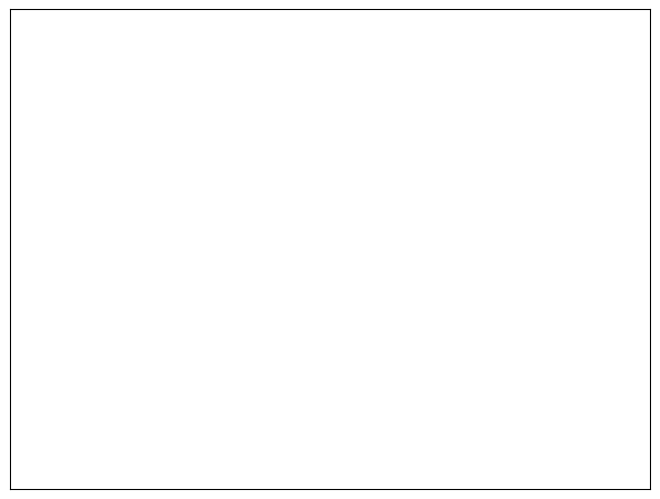

In [109]:
import networkx as nx
import matplotlib.pyplot as plt
import os 
plt.style.use('default')

os.makedirs('2hop', exist_ok=True)

def mapping_node_idx(edge_index, mapping_dict):
    return [[mapping_dict[num] for num in sub_array] for sub_array in edge_index] 

for i in range(20):
    src, dst = sample.loc[i, 'pid1'], sample.loc[i, 'pid1']
    subgraph = sample.loc[i, 'subgraph_1hop']
    subgraph = mapping_node_idx(subgraph, node_id_mapping)

    cora_graph = nx.DiGraph(directed=True)
    cora_graph.add_edges_from(torch.tensor(subgraph).numpy().T)

    pos = nx.spring_layout(cora_graph)  # 定义节点布局
    nx.draw(cora_graph, pos, with_labels=True, node_color='lightblue', node_size=300, edge_color='gray', )  # 绘制图
    
    plt.savefig(f'2hop/{i}_masked.png')
    
    # # 清空画布
    plt.cla()
